In this notebook we want to implement a first example of Quantum Machine Learning applied to a dataset.

In classical Machine Learning you usually start with the MNIST dataset and therefore we want to tackle it in this example as well!

Although this model is not "serious" in the sense that it wont be competitive with classical models and there is no "advantage", it is a nice example to get used to pennylane and the workflow to train qml models.

In [ ]:
!pip install pennylane --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.3/48.3 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 43.7 MB/s eta 0:00:00


First we import some neccesary packages. We will again use pennylane for all things quantum!

In [ ]:
import pennylane as qml
import pennylane.numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

## Data

Next we will download the MNIST dataset from keras and normalize it.

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# Rescale the images from [0,255] to the [0.0,1.0] range.
x_train, x_test = x_train[..., np.newaxis]/255.0, x_test[..., np.newaxis]/255.0

print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

11490434/11490434 [==============================] - 0s 0us/step
Number of original training examples: 60000
Number of original test examples: 10000


In order to simplify the problem, we will restrict us to a subset of the full dataset.

In [ ]:
n_train_per_class = 200
n_test_per_class = 1000

Furthermore, we will limit to the images of threes and sixes, to have a binary classification problem.
To do so, we filter out the images from the training data based on the label.

In [ ]:
def filter_36(x, y, n_samples):
    keep3 = (y == 3)
    keep6 = (y == 6)
    x = np.concatenate((x[keep3][:n_samples], x[keep6][:n_samples]))
    y = np.concatenate((y[keep3][:n_samples], y[keep6][:n_samples]))
    y = y == 3
    y = 2*y - 1
    return shuffle(x, y, random_state = 0)

In [ ]:
x_train, y_train = filter_36(x_train, y_train, n_train_per_class )
x_test, y_test = filter_36(x_test, y_test, n_test_per_class )

print("Number of filtered training examples:", len(x_train))
print("Number of filtered test examples:", len(x_test))

Number of filtered training examples: 400
Number of filtered test examples: 1958


Let's have a look at an example image

1


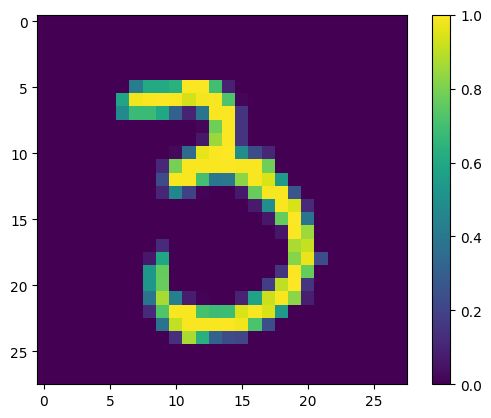

In [ ]:
print(y_train[0])

plt.imshow(x_train[0, :, :, 0])
plt.colorbar()

A single images has 28x28=784 pixels, which are the features of our classification task. To use a smaller amount of qubits, we will reduce the dimensionality of the dataset.
In this example we will use a data embedding of a single feature per qubit, therefore reducing the dataset to the number of qubits.

To do we will use a principle component analysis. Now this is a very simple technique for dimensionality reduction, however, we need to be careful with the interpretation of the results. Although the PCA is quite simple, it can be a powerful tool on simple datasets like MNIST.

The resulting principle components might already seperate the two classes sufficiently, that a cut on a single feature after the PCA gives a good calssification accuracy.

In [ ]:
n_qubits = 3
n_features = n_qubits

In [ ]:
pca = PCA(n_components=n_features)
x_train = pca.fit_transform(x_train.reshape(-1, 28 * 28))
cumsum = np.cumsum(pca.explained_variance_ratio_ * 100)[-1]
print("Cumulative sum on train :", cumsum)

x_test = pca.transform(x_test.reshape(-1, 28 * 28))
cumsum = np.cumsum(pca.explained_variance_ratio_ * 100)[-1]
print("Cumulative sum on train :", cumsum)

Cumulative sum on train : 33.99260841495339
Cumulative sum on train : 33.99260841495339


In [ ]:
norm = np.max(x_train)

x_train = x_train/norm*np.pi
x_test = x_test/norm*np.pi

As an example we will plot a single principle

(array([ 6.,  5., 18., 26., 36., 32., 34., 30.,  8.,  5.]),
 array([-0.37953112, -0.02741875,  0.32469363,  0.67680601,  1.02891839,
         1.38103077,  1.73314314,  2.08525552,  2.4373679 ,  2.78948028,
         3.14159265]),
 [<matplotlib.patches.Polygon at 0x7f165fc4de10>])

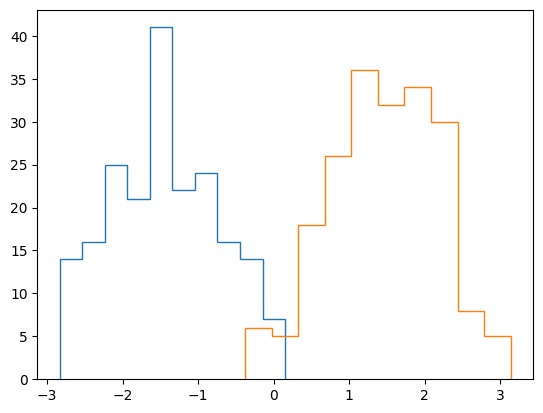

In [ ]:
plt.hist(x_train[:,0][y_train == -1],histtype='step')
plt.hist(x_train[:,0][y_train == 1],histtype='step')

As we can see, the PCA already separates the two classes on the first component sufficiently, so that the classification becomes a trivial problem.

However, as an example, we will still try to classify this dataset and are expecting to obtain good results on the classification.

## Circuit setup

We will now set up the circuits for our model. We will start with a very simple quantum neural network.

The network will consist of
1. A circuit to load the classical data into a quantum state
2. A parametrized quantum circuit corresponding to the classifier
3. A measurement to perform the classification

First we create a device

In [ ]:
dev = qml.device('lightning.qubit', wires=n_qubits)

Next we write the circuit to embed the data. Here we use the simplest embedding possible called 'Angle Embedding'.
It embeds a single feature on a single qubit, by rotating the state of the qubit by an angle corresponding to the classical feature value. If we denote our features by $x_i$ and choose to rotate around the $x$ axis of the bloch sphere the embedding would be
$$R_x(x_i)\big|\ 0\big>.$$

In [ ]:
def embedding(data):
  for idx, x in enumerate(data):
    qml.RX(x,wires=idx)

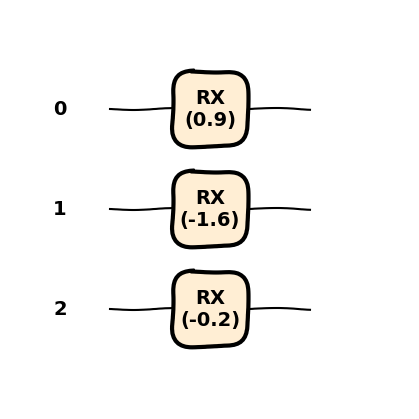

In [ ]:
import matplotlib.pyplot as plt
qml.draw_mpl(embedding, decimals=1, style="sketch")(x_train[0])
plt.show()

Next up, we will construct the parameterized circuit corresponding to our model. In general, there are not many guidelines how to do this yet. In this example, we will use a popular heuristic ansatz consiting of a layer of arbitrary qubit rotations and entanglement by CNOTs in an circular topology.

This layer is also implemented in pennylane as [StronglyEntanglingLayer](https://docs.pennylane.ai/en/stable/code/api/pennylane.StronglyEntanglingLayers.html), however as an exercise, we will implement it by hand here.

In [ ]:
def layer(params):
  for i in range(n_qubits):
    qml.RZ(params[i],wires=i)
  for i in range(n_qubits):
    qml.RY(params[i+n_qubits],wires=i)
  for i in range(n_qubits):
    qml.RZ(params[i+2*n_qubits],wires=i)
  for i in range(n_qubits):
    if i < n_qubits - 1:
      qml.CNOT(wires=[i,i+1])
    else:
      qml.CNOT(wires=[i,0])

Alternatively we could use pennylanes inbuild method (note in this case params needs to take a certain shape, see the [documentation](https://docs.pennylane.ai/en/stable/code/api/pennylane.StronglyEntanglingLayers.html)):

In [ ]:
def layer_pennylane(params):
  qml.StronglyEntanglingLayers(params, wires=range(n_qubits))

Now we can build a model circuit by adding an arbitrary number of subsequent layers.

In [ ]:
layers = 3

In [ ]:
def model_pqc(params):
  for i in range(layers): layer(params[i*3*n_qubits:(i+1)*3*n_qubits])

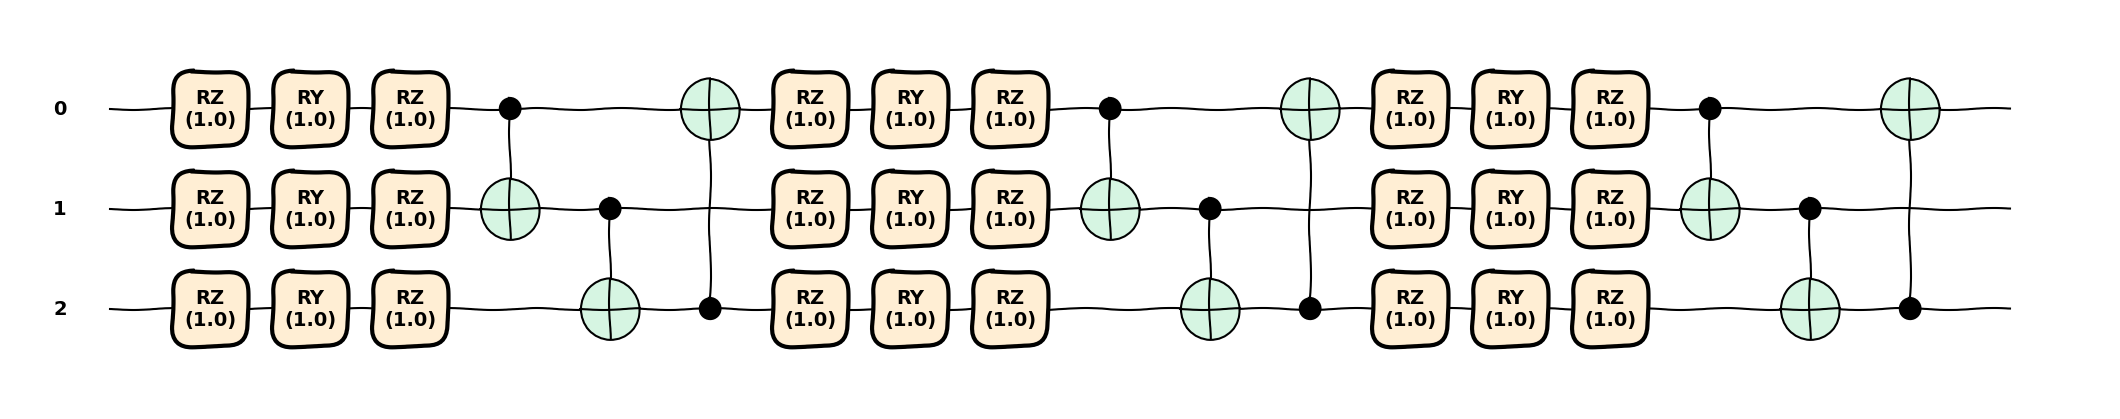

In [ ]:
qml.draw_mpl(model_pqc, decimals=1, style="sketch")(np.ones(layers*3*n_qubits))
plt.show()

Now we are ready to build our final training circuit. This circuit will include the data embedding, the model pqc and a measurement, and we will create it as a QNode, as it will be the final circuit we will be executing. As measurement, we will be measureing the qubit 0.

In [ ]:
@qml.qnode(dev)
def training_circuit(data, params):
  embedding(data)
  model_pqc(params)
  return qml.expval(qml.PauliZ(0))

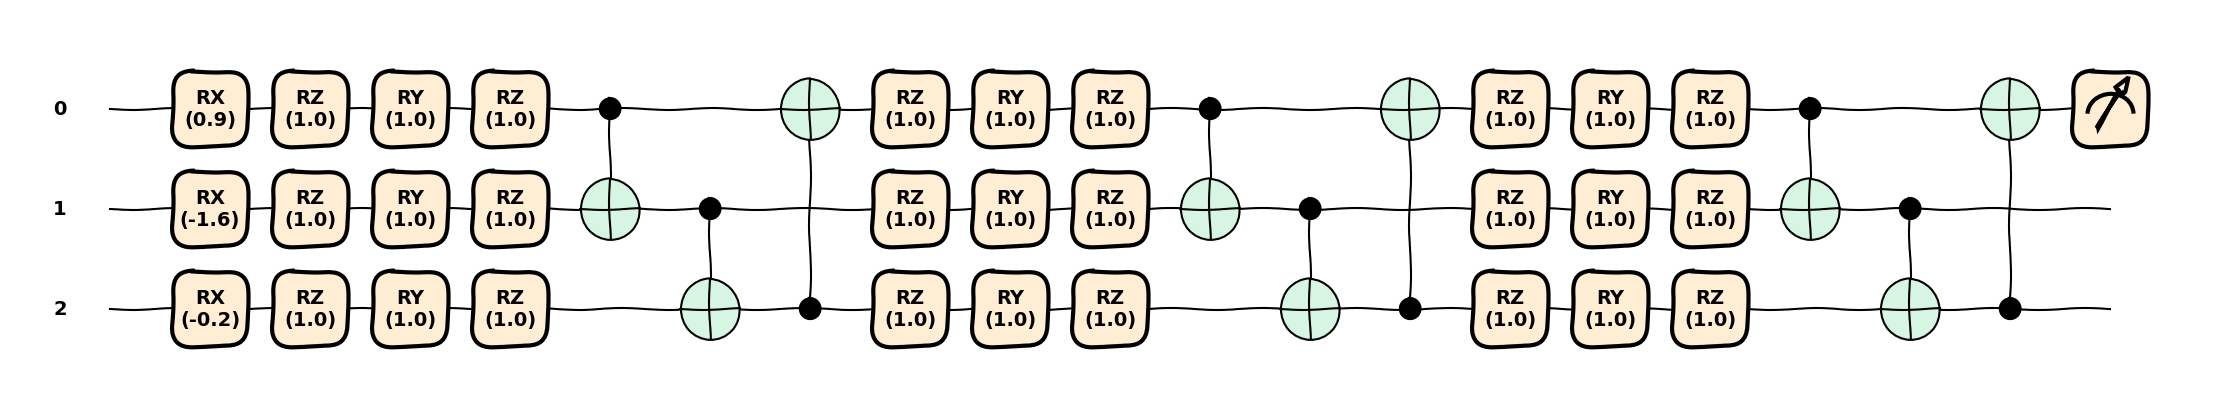

In [ ]:
qml.draw_mpl(training_circuit, decimals=1, style="sketch")(x_train[0], np.ones(layers*3*n_qubits))
plt.show()

# Training

To train the circuit, we will define a loss function and an optimizer which will train our parameters while we loop over the training data.

In our training dataset we assigned the labels $1$ and $-1$ to our two classes.
In our training circuit we are measuring in the PauliZ basis. Since $\sigma_z$ has eigenvalues $\pm 1$ the measurement results exaclty corresponds to the label of the class.

We can therefore write down a simple loss function. Here we will use the [Hinge loss](https://en.wikipedia.org/wiki/Hinge_loss), which expects the labels to be $\pm 1$.

Note, that we construct the loss function to take in a batch of data and the parameters of the circuit.

In [ ]:
def loss(batch_x, batch_y, params):
  loss = 0
  for idx, x in enumerate(batch_x):
    y_pred = training_circuit(x,params)
    loss += np.maximum(1 - batch_y[idx] * y_pred, 0)
  return loss / len(batch_x)

Like in th eprevious examples we will now define our initial parameters. Here we again have to specify the keyword **requires_grad** to indicate that these are parameters we want to optimize.

In [ ]:
params = np.array(np.random.uniform(size=layers*3*n_qubits), requires_grad=True)*np.pi

To loop over our data we furthermore write a function to split our data into batches

In [ ]:
def iterate_minibatches(dataX, dataY, batch_size):
    for start_idx in range(0, dataX.shape[0] - batch_size + 1, batch_size):
        idxs = slice(start_idx, start_idx + batch_size)
        yield dataX[idxs], dataY[idxs]

In [ ]:
def accuracy(dataX, dataY, params):
  acc = 0
  for idx, x in enumerate(dataX):
    pred = -1 if training_circuit(x, params) < 0 else 1
    if pred == dataY[idx]: acc += 1
  return acc / len(dataX)


Now we are ready to train!
We define the training parameters and the optimizer

In [ ]:
epochs = 10
batch_size = 16
lr = 0.01

In [ ]:
opt = qml.AdamOptimizer(stepsize=lr)

And write down the training loop. Note, that we define the cost function with a [lambda function](https://www.w3schools.com/python/python_lambda.asp) for every batch of data, since our optimizer expects a function with a single argrument, which will be optimized.

For every epoch, we loop over all batches of data and perform an optimzation step for every batch.

In [ ]:
import time
start = time.time()

loss_hist = []
acc_hist = []

for it in range(epochs):
    for j,data in enumerate(iterate_minibatches(x_train, y_train, batch_size=batch_size)):
        Xbatch, Ybatch = data
        cost_fn = lambda p: loss(Xbatch, Ybatch, p)
        params = opt.step(cost_fn, params)
        print(j, end="\r")

    loss_val = loss(x_train, y_train, params)
    acc = accuracy(x_train, y_train, params)

    loss_hist += [loss_val]
    acc_hist += [acc]

    print(f"Epoch: {it} | Loss: {loss_val:.3} | acc: {acc:.3} ")
    print("____")

end = time.time()

print(f"Time for {epochs} epochs: {end - start}")

Epoch: 0 | Loss: 0.718 | acc: 0.848 
____
Epoch: 1 | Loss: 0.513 | acc: 0.955 
____
Epoch: 2 | Loss: 0.404 | acc: 0.978 
____
Epoch: 3 | Loss: 0.299 | acc: 0.983 
____
Epoch: 4 | Loss: 0.254 | acc: 0.98 
____
Epoch: 5 | Loss: 0.239 | acc: 0.983 
____
Epoch: 6 | Loss: 0.233 | acc: 0.983 
____
Epoch: 7 | Loss: 0.23 | acc: 0.98 
____
Epoch: 8 | Loss: 0.229 | acc: 0.98 
____
Epoch: 9 | Loss: 0.228 | acc: 0.98 
____
Time for 10 epochs: 1105.9370548725128


Text(0, 0.5, 'loss')

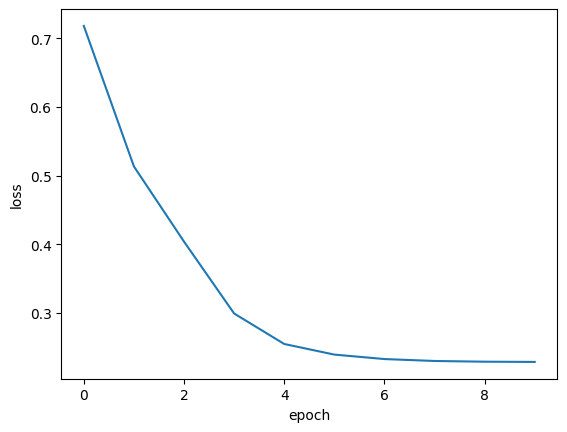

In [ ]:
plt.plot(loss_hist)
plt.xlabel("epoch")
plt.ylabel("loss")

Text(0, 0.5, 'Accuracy')

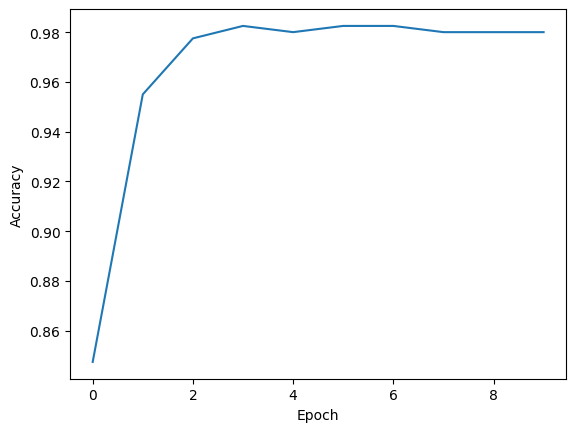

In [ ]:
plt.plot(acc_hist)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")